In [375]:
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.image as mpimg #for image reading
import csv                       #for csv reading
from matplotlib import colors

try:
    import QOL.plots as pqol #custom plotting stuff for Sam
    pqol.fixfigsize((1,1))
    pqol.scale_fonts((2,2))
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

import ImageProcessing as ip #ProjectOAK file with image processing functions.
import  DataProcessing as dp #ProjectOAK file with data  processing functions.
#''' #comment this line if actively editting ImageProcessing.py, to force reloads.
from importlib import reload 
reload(ip)
reload(dp)
#''';

CSVFILE = dp.CSVFILE2
IMAGESFOLDER = dp.IMAGESFOLDER2J

In [326]:
## get data from csv file about pokemon.
csvdata, cc = dp.read_csv(dp.CSVFILE2)

In [390]:
# some examples of convenient functions from DataProcessing, to help interact with the data:
print('>1>)',dp.poke_to_N('Charizard', csvdata))
print('>2>)',dp.N_to_poke(6, csvdata, code=1)) #can pass numbers as number or str(number).
print('>3>)',dp.N_to_poke(6, csvdata))
print('>4>)',dp.N_to_S(6, csvdata))
print('>5>)',dp.S_to_poke(61, csvdata))
print('>6>)',dp.S_to_N(61, csvdata))
print('>7>)',dp.poke_to_S('Charizard', csvdata))
#note that serial number = pokemon number + code, and code=1 for base forms of pokemon (the usual forms you are used to).

>1>) ['6']
>2>) ['Charizard']
>3>) ['Charizard' 'Mega Charizard X' 'Mega Charizard Y']
>4>) ['61' '62' '63']
>5>) ['Charizard']
>6>) ['6']
>7>) ['61']


In [391]:
# some examples which demonstrate more precise ways to interact with this data:
print('>1>)', cc)
print('')
print('>2>)', cc._asdict())
print('')
print('>3>)', csvdata.shape)
print('')
row = np.where(csvdata=='Pikachu')[0][0]
print('>4>)', csvdata[row])                #the entire row for row=row
print('')
print('>5>)', csvdata[row,cc.NUMBER], csvdata[row,cc.SERIAL], csvdata[row,cc.TYPE1]) #NUMBER, SERIAL, and TYPE1 for row=row
print('')
print('>6>)', csvdata[:,cc.NUMBER])        #the entire column for column=cc.NUMBER; i.e. all the info about pokemon NUMBERs.
print('')
print('>7>)', csvdata[:,cc.NAME])          #the entire column for column=cc.NAME;   i.e. all the info about pokemon NAMEs.

>1>) indices(NUMBER=0, CODE=1, SERIAL=2, NAME=3, TYPE1=4, TYPE2=5, COLOR=6, ABILITY1=7, ABILITY2=8, ABILITY_HIDDEN=9, GENERATION=10, LEGENDARY=11, MEGA_EVOLUTION=12, HEIGHT=13, WEIGHT=14, HP=15, ATK=16, DEF=17, SP_ATK=18, SP_DEF=19, SPD=20, TOTAL=21)

>2>) OrderedDict([('NUMBER', 0), ('CODE', 1), ('SERIAL', 2), ('NAME', 3), ('TYPE1', 4), ('TYPE2', 5), ('COLOR', 6), ('ABILITY1', 7), ('ABILITY2', 8), ('ABILITY_HIDDEN', 9), ('GENERATION', 10), ('LEGENDARY', 11), ('MEGA_EVOLUTION', 12), ('HEIGHT', 13), ('WEIGHT', 14), ('HP', 15), ('ATK', 16), ('DEF', 17), ('SP_ATK', 18), ('SP_DEF', 19), ('SPD', 20), ('TOTAL', 21)])

>3>) (1052, 22)

>4>) ['25' '1' '251' 'Pikachu' 'Electric' '' 'Yellow' 'Static' ''
 'Lightning Rod' '1' '0' '0' '0.4' '6' '35' '55' '40' '50' '50' '90' '320']

>5>) 25 251 Electric

>6>) ['1' '2' '3' ... '898' '898' '898']

>7>) ['Bulbasaur' 'Ivysaur' 'Venusaur' ... 'Calyrex' 'Calyrex' 'Calyrex']


## Get all the images of pokemon!

In [285]:
allimages = ip.get_all_images(IMAGESFOLDER)

got all 819 images in   1.7 seconds (from folder = dataset/images/archive/pokemon_jpg/pokemon_jpg)


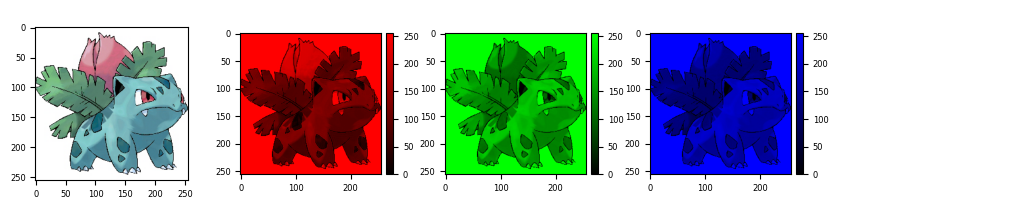

In [288]:
ip.show_rgb(allimages['2'])

## TODO:
- convert numbers to pokemon names using dp.N_to_poke with code=1. (this just makes things easier to read)
- bring together images & labels appropriately; put into neural network.

# (11/27/20) Stopping point
Notes:
- Moved a lot of stuff to ImageProcessing.py and DataProcessing.py.
- shouldn't be too much more work until the data is ready to be run through a network; I just had to stop abruptly because it was dinnertime!
- **Below this point is old stuff from the notebook; it doesn't take advantage of the ImageProcessing.py and DataProcessing.py stuff, and doesn't use the new data.**
---

In [5]:
IMAGESHAPE = allimages[next(iter(allimages))].shape #next(iter(dict)) gets first key in dict.
print("shape of images:",IMAGESHAPE)

shape of images: (120, 120, 3)


### put pokemon images in order

In [6]:
orderedimages = np.array([allimages[pokemon] for pokemon in pokedata[:,0]])
print("shape of image list:", orderedimages.shape)

shape of image list: (809, 120, 120, 3)


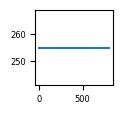

In [11]:
plt.plot(orderedimages.reshape(orderedimages.shape[0], -1).max(axis=-1))

#### function for checking data is loaded & ordered properly:

In [108]:
def inspect_poke(number, images=None, labels=None, pokedata=pokedata, pokenumber=True, showname=True):
    '''shows info about pokemon number <number>, to ensure data is loaded properly.'''
    pokeidx = number-1 if pokenumber else number #pokedata is 0-indexed
    if showname: print('{:d}: {:s}'.format(number, pokedata[pokeidx,0]))
    if labels is not None:
        l = labels[pokeidx]
        if np.isreal(l): print('type: ', l, ' (',i_to_type(l),')', sep='')
        else: print('type:',l)
    if images is not None: plt.imshow(images[pokeidx]); plt.show()

### Set data & labels - next we will do machine learning!

In [91]:
images = orderedimages
labels = type_to_i(pokedata[:,1])   #for now, just use the pokemon's primary type.

149: dragonite
type: 2 (Dragon)


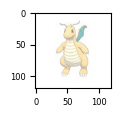

In [107]:
inspect_poke(149, images, labels)

## Single-type classification (the simplest problem)

In [10]:
## let's first make a single-label neural network which only assigns one type per pokemon.
# This is most similar to what we've done already.
# I think it should just ignore the info about secondary types.

# use: https://www.tensorflow.org/guide/data#reading_input_data to read inputs.


In [19]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [103]:
def splitdata(data, labels, val_size=0.2, test_size=0.1):
    '''returns dict with train, val, test sets.
    test_size = portion of data for test. val_size = portion of data for validation.'''
    TS = val_size + test_size
    TF = test_size/val_size
    X_train, Xt, Y_train, Yt     = train_test_split(data, labels, test_size=TS, train_size=1.0-TS)
    X_val, X_test, Y_val, Y_test = train_test_split(Xt,   Yt,     test_size=TF, train_size=1.0-TF)
    return {'train': {'data':X_train, 'labels':Y_train},
            'val'  : {'data':X_val,   'labels':Y_val  },
            'test' : {'data':X_test,  'labels':Y_test }}

#do scaling
def get_scaler(data):
    '''returns scaler for data. (remember to only input training data here.)'''
    s = StandardScaler()
    s.fit_transform(data.reshape(data.shape[0], -1))
    return s

def scale_images(data, scaler):
    shape = data.shape
    return scaler.transform(data.reshape(shape[0], -1)).reshape(shape)

def scaled_datasets(dd):
    '''returns scaled splitdata. ( suggested use: scaled(splitdata(data, labels)) )'''
    s = get_scaler(dd['train']['data'])
    return {key:{'data':scale_images(dataset['data'], s), 'labels':dataset['labels']} for key, dataset in dd.items()}

def plt_scaled(img, **imshow_kwargs):
    '''plots scaled img; rather than clipping values not in [0,1], makes all values fit in [0,1]'''
    plt.imshow(img/(2*np.abs(img).max())+0.5, **imshow_kwargs)

In [94]:
sc = get_scaler(images)

In [95]:
si = scale_images(images, sc)

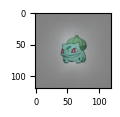

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


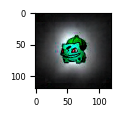

In [105]:
plt_scaled(si[0]); plt.show()
plt.imshow(si[0]); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


149: dragonite
type: 2 (Dragon)


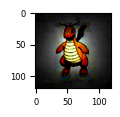

In [96]:
inspect_poke(149, si, labels)

In [56]:
dd = scaled_datasets(splitdata(images, labels, 0.2, 0.1))
print(dd['train']['data'].shape)
print(dd['val']['data'].shape)
print(dd['test']['data'].shape)

(566, 120, 120, 3)
(121, 120, 120, 3)
(122, 120, 120, 3)


In [22]:
dd['train']['data'].max()

255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


type: 16 (Steel)


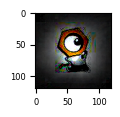

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


type: 3 (Electric)


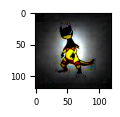

In [58]:
## check that types are still aligned properly
checkit = dd['val']
for i in range(2): inspect_poke(i,checkit['data'],checkit['labels'],pokenumber=False,showname=False)

### set up model

In [122]:
def create_CNN():
    num_classes = NTYPES+1

    model = models.Sequential()
    model.add(layers.Conv2D(3, (3,3), input_shape = IMAGESHAPE))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes * 2, activation = 'relu'))
    model.add(layers.Dense(num_classes, activation = 'softmax'))

    model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     metrics = ['accuracy'])


    # model = models.Sequential()
    # model.add(layers.Conv2D(10, (2,2), activation='relu', input_shape=IMAGESHAPE))
    # model.add(layers.MaxPooling2D((3, 3)))
    # model.add(layers.Conv2D(20, (2,2), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(40, (2,2), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(100, activation='relu'))
    # model.add(layers.Dense(NTYPES, activation='softmax'))


    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"),
    #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #               metrics=['sparse_categorical_accuracy'])
    # model.compile(optimizer=tf.keras.optimizers.RMSprop(),
    #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #               metrics=['sparse_categorical_accuracy'])
    #model.summary()
    return model

In [123]:
epochs = 15
batch_size = 32
verbose = 1

model = create_CNN()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
history = model.fit(dd['train']['data'], dd['train']['labels'], validation_data=(dd['val']['data'], dd['val']['labels']),
                      batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[callback])

# train the data for 500 epochs
#model.fit(data_train, labels_train, batch_size = 32, epochs = 500, verbose=1, validation_split = 0.1)
#model.evaluate(dd['val']['data'], dd['val']['labels'])

Epoch 1/15
18/18 [==============================] - 1s 51ms/step - loss: 2.9314 - accuracy: 0.0813 - val_loss: 2.9421 - val_accuracy: 0.0826
Epoch 2/15
18/18 [==============================] - 1s 39ms/step - loss: 2.8664 - accuracy: 0.2049 - val_loss: 2.9314 - val_accuracy: 0.0909
Epoch 3/15
18/18 [==============================] - 1s 40ms/step - loss: 2.8143 - accuracy: 0.2544 - val_loss: 2.9363 - val_accuracy: 0.1074
Epoch 4/15
18/18 [==============================] - 1s 43ms/step - loss: 2.7597 - accuracy: 0.3339 - val_loss: 2.9351 - val_accuracy: 0.0661
Epoch 5/15
18/18 [==============================] - 1s 39ms/step - loss: 2.7151 - accuracy: 0.3710 - val_loss: 2.9266 - val_accuracy: 0.0909
Epoch 6/15
18/18 [==============================] - 1s 39ms/step - loss: 2.6815 - accuracy: 0.4011 - val_loss: 2.9249 - val_accuracy: 0.0909
Epoch 7/15
18/18 [==============================] - 1s 39ms/step - loss: 2.6540 - accuracy: 0.4240 - val_loss: 2.9160 - val_accuracy: 0.0992
Epoch 8/15
18

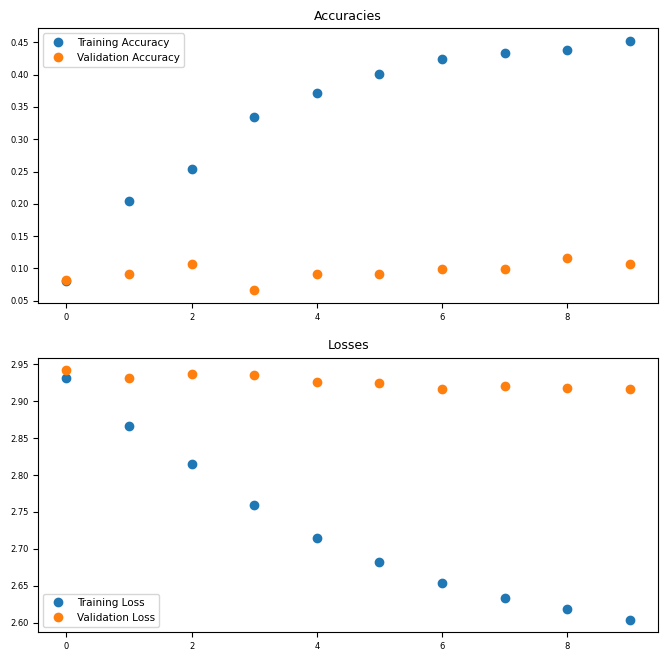

Maximum validation accuracy achieved: 0.11570248007774353


In [124]:
epochs = len(history.history['loss'])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(epochs), history.history['accuracy'], 'o', label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], 'o', label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(range(epochs), history.history['loss'], 'o', label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], 'o', label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.show()

print("Maximum validation accuracy achieved: " + str(np.max(history.history['val_accuracy'])))

prediction (validation data)


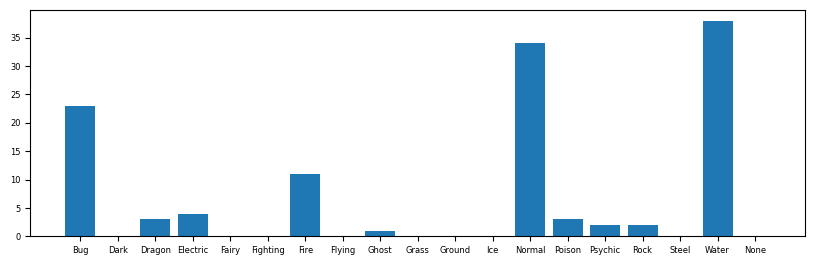

data (validation data)


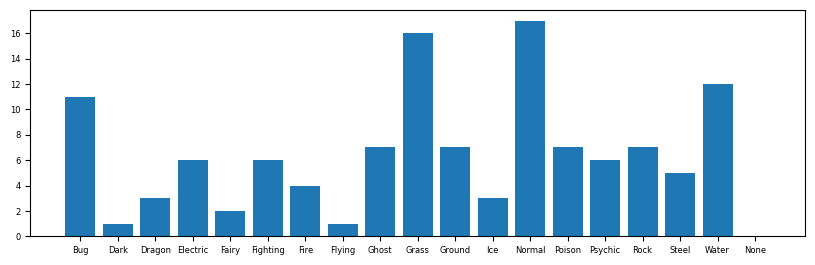

In [125]:
#predictions = onehot_to_i(model.predict(dd['val']['data']))
predictions = prediction_to_i(model.predict(dd['val']['data'])) #prediction = type with max probability.
assert len(predictions)==len(dd['val']['data'])
print('prediction (validation data)')
plt.figure(figsize=(10,3))
bc_p = np.bincount(predictions, minlength=NTYPES+1)
plt.bar(alltypes, bc_p);
plt.show()
print('data (validation data)')
plt.figure(figsize=(10,3))
bc_s = np.bincount(dd['val']['labels'], minlength=NTYPES+1)
plt.bar(alltypes, bc_s);
plt.show()

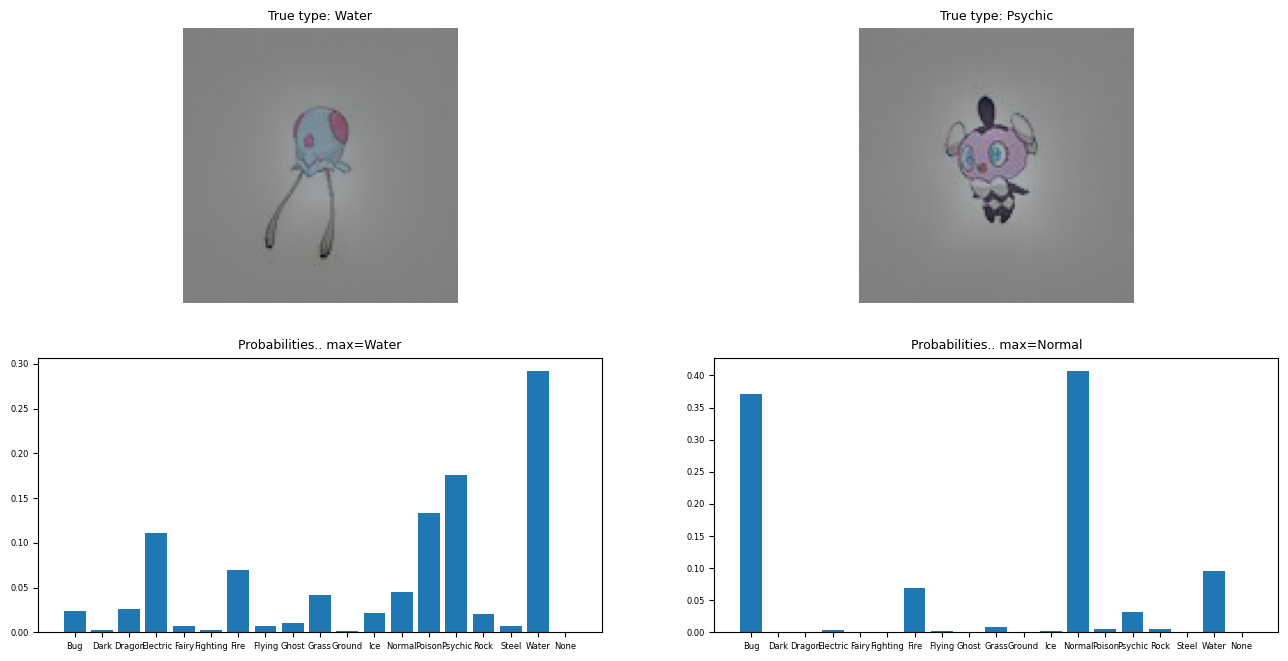

In [128]:
istart = 8
istop  = 10
SAMPLES = istop - istart
slicer = slice(istart, istop, None)

plt.figure(figsize=(16, 8))
imgs = dd['val']['data'][slicer]
lbls = dd['val']['labels'][slicer]
predictions = model.predict(imgs)
for i in range(SAMPLES):
    ax = plt.subplot(2, SAMPLES, i + 1)
    plt_scaled(imgs[i])
    arr = np.array(labels[i])
    index = np.where(arr == 1)
    plt.title("True type: " + str(i_to_type(lbls[i])))
    plt.axis("off")

    plt.subplot(2, SAMPLES, i + SAMPLES + 1)
    plt.title("Probabilities.. max="+str(i_to_type(prediction_to_i(predictions[i]))))
    plt.bar(alltypes, predictions[i])

Note for future... it seems the model is predicting only one label for each case (rather than a probability distribution), and seems to be labeling everything with the same type. Look into architecture/more stuff to help fuix this, next time.

In [ ]:
N_examine = 3
predicted = onehot_to_type(model.predict(dd['val']['data'][:N_examine]))
for i in range(N_examine):
    print('predicted:',predicted[i])
    inspect_poke(i, dd['val']['data'], dd['val']['labels'], pokenumber=False, showname=False)

In [ ]:
''' this doesnt really do anything good apparently. (not needed for model.fit())
train_dataset = tf.data.Dataset.from_tensor_slices((dd['train']['data'], dd['train']['labels']))
val_dataset   = tf.data.Dataset.from_tensor_slices((dd['val']['data'],   dd['val']['labels']  ))
test_dataset  = tf.data.Dataset.from_tensor_slices((dd['test']['data'],   dd['test']['labels']))
#''';

## Multi-label classification (a non-trivial generalization?)

In [ ]:
## We want to have images be assigned two labels (the second label possibly being 'None').
# apparently this problem (of assigning multiple labels) is known more generally as 'Multi-label classification'.
# it might be nontrivial.

## Some thoughts:
# - I think it will be cool to see if including two labels actually leads to improvements on accuracy...
# - I feel like usually type1 and type2 are correlated (e.g. more likely to get a grass+poison poke than grass+fire).
#    I wonder how we can incorporate these correlations, or if we should even incorporate them at all.
#    Would a neural network be able to learn these correlations?